# LangGraph Exercise: Product Advisor Assistant Guardrails

This exercise focuses on building a conversational **Product Advisor Assistant** using LangGraph. The core challenge is to implement a multi-step decision tree to guide the user to the right product while incorporating **guardrails** to handle off-topic or inappropriate queries.

## Idea: Product Recommendation Flow
The assistant will recommend one of three hypothetical financial products based on user input:
1. **Savings Account:** For low-risk, short-term goals.
2. **Index Fund:** For medium-risk, long-term goals.
3. **High-Yield Bond:** For high-risk, income-focused goals.

## Approach: Decision Tree with Conditional Edges
The graph will use a series of conditional nodes (LLM calls with structured output) to determine the user's intent and risk profile, guiding the conversation down the correct path.

## Structure: Guardrail First
The first node will be a **Guardrail Node** to check for compliance and safety. Only if the query is safe and on-topic will the flow proceed to the **Decision Tree**.

| Node Type | Function | Purpose |
| :--- | :--- | :--- |
| **Guardrail** | LLM + Pydantic | Checks if the query is on-topic (Financial Advice) or off-topic/unsafe. |
| **Risk Profiler** | LLM + Pydantic | Determines user's risk tolerance (Low, Medium, High). |
| **Goal Assessor** | LLM + Pydantic | Determines user's time horizon (Short-term, Long-term). |
| **Product Nodes** | Simple Function | Provides the final product recommendation. |
| **Fallback Node** | Simple Function | Handles off-topic/unsafe queries. |

## Prerequisites
1. Python environment with `langchain`, `langgraph`, `langchain-openai`, `pydantic`.
2. Azure OpenAI Service deployment named `gpt-4.1-mini`.
3. Azure OpenAI API Key and Endpoint.

In [4]:
!pip install langchain langchain-openai langchain-core langsmith langgraph openai python-dotenv pydantic --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 11.6 MB/s eta 0:00:00


In [5]:
# Install required packages
print('Required packages are assumed to be installed.')

Required packages are assumed to be installed.


In [6]:
import os
from typing import Literal, TypedDict
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph import StateGraph, END


In [ ]:
# --- Environment Variable Setup (Replace with your actual values or set them in your environment) ---
# NOTE: In a real environment, these should be set externally for security.
os.environ["LANGSMITH_API_KEY"] = os.environ.get("LANGSMITH_API_KEY", "xxxxxxxxxxx")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.environ.get("AZURE_OPENAI_ENDPOINT", "https://eastus.api.cognitive.microsoft.com/")
os.environ["AZURE_OPENAI_API_KEY"] = os.environ.get("AZURE_OPENAI_API_KEY", "xxxxxxxxxxx")
os.environ["OPENAI_API_VERSION"] = os.environ.get("OPENAI_API_VERSION", "2024-08-01-preview")
os.environ["LANGSMITH_TRACING"] = "true"
AZURE_OPENAI_DEPLOYMENT='gpt-4.1-mini'

print('Environment variables configured (using placeholders).')
print(f'LLM Deployment: {AZURE_OPENAI_DEPLOYMENT}')

Environment variables configured (using placeholders).
LLM Deployment: gpt-4.1-mini


In [9]:
# Initialize AzureChatOpenAI LLM
try:
    llm = AzureChatOpenAI(
        openai_api_version="2024-02-01",
        azure_deployment=AZURE_OPENAI_DEPLOYMENT,
        temperature=0
    )
    print("AzureChatOpenAI LLM initialized successfully.")
except Exception as e:
    print(f"ERROR: Could not initialize AzureChatOpenAI: {e}")
    print("The notebook will continue, but LLM-dependent cells will use placeholders.")


AzureChatOpenAI LLM initialized successfully.


## Product Advisor Assistant

This exercise implements a multi-step decision tree, starting with a crucial **Guardrail** to ensure the conversation remains on-topic and safe.


In [10]:
# Define State, Guardrail Schema, and Guardrail Node Function
class AdvisorState(TypedDict):
    query: str
    guardrail_status: Literal["safe", "unsafe"]
    risk_profile: Literal["low", "medium", "high", "unknown"]
    time_horizon: Literal["short", "long", "unknown"]
    recommendation: str


class GuardrailDecision(BaseModel):
    status: Literal["safe", "unsafe"] = Field(
        ..., description="Must be 'safe' if query is financial; otherwise 'unsafe'."
    )


def guardrail_node(state: AdvisorState) -> AdvisorState:
    print(f"--- Guardrail Node: Checking Query: {state['query']} ---")
    if llm is None:
        print("LLM not initialized. Defaulting to 'safe'.")
        return {"guardrail_status": "safe"}
    guardrail_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a safety guardrail. Determine if the user's query is related to financial advice or products. "
                   "If it is, output 'safe'. If off-topic, inappropriate, or harmful, output 'unsafe'. "
                   "Your output MUST be a JSON object conforming to the provided schema."),
        ("human", "User Query: {query}")
    ])
    try:
        guardrail_chain = guardrail_prompt | llm.with_structured_output(GuardrailDecision)
        decision = guardrail_chain.invoke({"query": state["query"]})
        status = decision.status
        print(f"--- Guardrail Status: {status} ---")
        return {"guardrail_status": status}
    except Exception as e:
        print(f"ERROR in guardrail chain: {e}. Defaulting to 'unsafe'.")
        return {"guardrail_status": "unsafe"}


In [11]:
# Define Decision Tree Schemas and Nodes
class RiskProfile(BaseModel):
    profile: Literal["low", "medium", "high"]


class TimeHorizon(BaseModel):
    horizon: Literal["short", "long"]


def risk_profiler_node(state: AdvisorState) -> AdvisorState:
    print("--- Risk Profiler Node: Assessing Risk ---")
    if llm is None:
        return {"risk_profile": "unknown"}
    risk_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a financial risk assessor. Output JSON for risk tolerance."),
        ("human", "User Query: {query}")
    ])
    try:
        risk_chain = risk_prompt | llm.with_structured_output(RiskProfile)
        profile = risk_chain.invoke({"query": state["query"]}).profile
        print(f"--- Risk Profile: {profile} ---")
        return {"risk_profile": profile}
    except:
        return {"risk_profile": "unknown"}

In [12]:



def goal_assessor_node(state: AdvisorState) -> AdvisorState:
    print("--- Goal Assessor Node: Assessing Time Horizon ---")
    if llm is None:
        return {"time_horizon": "unknown"}
    horizon_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a financial goal assessor. Output JSON for short or long term."),
        ("human", "User Query: {query}")
    ])
    try:
        horizon_chain = horizon_prompt | llm.with_structured_output(TimeHorizon)
        horizon = horizon_chain.invoke({"query": state["query"]}).horizon
        print(f"--- Time Horizon: {horizon} ---")
        return {"time_horizon": horizon}
    except:
        return {"time_horizon": "unknown"}

In [13]:
# Product Recommendation Nodes and Fallback
def recommend_savings(state: AdvisorState) -> AdvisorState:
    rec = "Recommendation: **High-Interest Savings Account** for low-risk, short-term goals."
    return {"recommendation": rec}


def recommend_index_fund(state: AdvisorState) -> AdvisorState:
    rec = "Recommendation: **Diversified Index Fund** for medium-risk, long-term goals."
    return {"recommendation": rec}


def recommend_bond(state: AdvisorState) -> AdvisorState:
    rec = "Recommendation: **High-Yield Corporate Bond** for high-risk, income-focused goals."
    return {"recommendation": rec}


def fallback_node(state: AdvisorState) -> AdvisorState:
    rec = ("Recommendation: **Guardrail Triggered**. Query off-topic or unsafe. "
           "I can only provide advice on financial products.")
    return {"recommendation": rec}


def final_recommendation_node(state: AdvisorState) -> AdvisorState:
    rec = (f"Recommendation: **General Advice**. Based on profile "
           f"(Risk: {state['risk_profile']}, Horizon: {state['time_horizon']}).")
    return {"recommendation": rec}


In [14]:


def product_decision(state: AdvisorState) -> str:
    risk = state["risk_profile"]
    horizon = state["time_horizon"]
    if risk == "low" and horizon == "short":
        return "savings"
    elif risk == "medium" and horizon == "long":
        return "index_fund"
    elif risk == "high":
        return "bond"
    else:
        return "default"

In [15]:
# Build and Compile the LangGraph
workflow = StateGraph(AdvisorState)
workflow.add_node("guardrail", guardrail_node)
workflow.add_node("risk_profiler", risk_profiler_node)
workflow.add_node("goal_assessor", goal_assessor_node)
workflow.add_node("savings", recommend_savings)
workflow.add_node("index_fund", recommend_index_fund)
workflow.add_node("bond", recommend_bond)
workflow.add_node("fallback", fallback_node)
workflow.add_node("default_rec", final_recommendation_node)

workflow.set_entry_point("guardrail")
workflow.add_conditional_edges(
    "guardrail",
    lambda x: "risk_profiler" if x["guardrail_status"] == "safe" else "fallback",
    {"risk_profiler": "risk_profiler", "fallback": "fallback"}
)
workflow.add_edge("risk_profiler", "goal_assessor")
workflow.add_conditional_edges(
    "goal_assessor", product_decision,
    {"savings": "savings", "index_fund": "index_fund", "bond": "bond", "default": "default_rec"}
)

workflow.add_edge("fallback", END)
workflow.add_edge("savings", END)
workflow.add_edge("index_fund", END)
workflow.add_edge("bond", END)
workflow.add_edge("default_rec", END)

app_advisor = workflow.compile()
print("LangGraph for Product Advisor Assistant compiled successfully.")

LangGraph for Product Advisor Assistant compiled successfully.


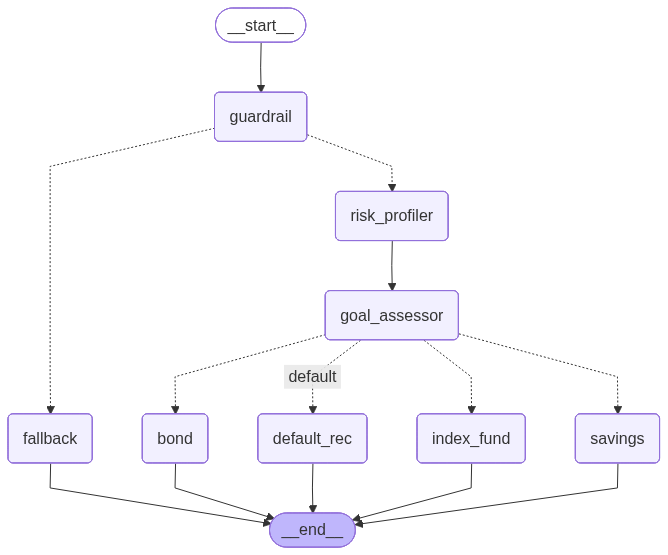

In [17]:
app_advisor

In [16]:
# Test Cases
query_1 = "I need a safe place to keep money for a down payment next year."
query_2 = "I want to invest for my retirement in 20 years and I'm comfortable with market volatility."
query_3 = "I need a high monthly income stream and I am willing to take on more risk."
query_4 = "What is the best recipe for a chocolate cake?"

for i, q in enumerate([query_1, query_2, query_3, query_4], start=1):
    print(f"\n--- Running Test Case {i}: {q} ---")
    result = app_advisor.invoke({"query": q})
    print(f"Final Recommendation: {result['recommendation']}")
    if 'guardrail_status' in result:
        print(f"Guardrail Status: {result['guardrail_status']}")
    else:
        print(f"Profile: Risk={result['risk_profile']}, Horizon={result['time_horizon']}")


--- Running Test Case 1: I need a safe place to keep money for a down payment next year. ---
--- Guardrail Node: Checking Query: I need a safe place to keep money for a down payment next year. ---


/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--- Guardrail Status: safe ---
--- Risk Profiler Node: Assessing Risk ---


/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--- Risk Profile: low ---
--- Goal Assessor Node: Assessing Time Horizon ---


/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--- Time Horizon: short ---
Final Recommendation: Recommendation: **High-Interest Savings Account** for low-risk, short-term goals.
Guardrail Status: safe

--- Running Test Case 2: I want to invest for my retirement in 20 years and I'm comfortable with market volatility. ---
--- Guardrail Node: Checking Query: I want to invest for my retirement in 20 years and I'm comfortable with market volatility. ---


/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--- Guardrail Status: safe ---
--- Risk Profiler Node: Assessing Risk ---


/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--- Risk Profile: high ---
--- Goal Assessor Node: Assessing Time Horizon ---


/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--- Time Horizon: long ---
Final Recommendation: Recommendation: **High-Yield Corporate Bond** for high-risk, income-focused goals.
Guardrail Status: safe

--- Running Test Case 3: I need a high monthly income stream and I am willing to take on more risk. ---
--- Guardrail Node: Checking Query: I need a high monthly income stream and I am willing to take on more risk. ---


/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--- Guardrail Status: safe ---
--- Risk Profiler Node: Assessing Risk ---


/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--- Risk Profile: high ---
--- Goal Assessor Node: Assessing Time Horizon ---


/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--- Time Horizon: short ---
Final Recommendation: Recommendation: **High-Yield Corporate Bond** for high-risk, income-focused goals.
Guardrail Status: safe

--- Running Test Case 4: What is the best recipe for a chocolate cake? ---
--- Guardrail Node: Checking Query: What is the best recipe for a chocolate cake? ---


/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--- Guardrail Status: unsafe ---
Final Recommendation: Recommendation: **Guardrail Triggered**. Query off-topic or unsafe. I can only provide advice on financial products.
Guardrail Status: unsafe


## Result Interpretation

1. **Guardrail First:** Queries flagged as unsafe are routed to the fallback node immediately.
2. **Sequential Flow:** Safe queries progress through risk and goal nodes.
3. **Conditional Recommendation:** Final output depends on both attributes.

---

## Conclusion

| Feature              | LangGraph Implementation                        | Benefit                          |
| :------------------- | :---------------------------------------------- | :------------------------------- |
| **Guardrails**       | Conditional edge from `guardrail` to `fallback` | Ensures compliance and safety    |
| **Decision Tree**    | Sequential structured LLM calls                 | Enables reasoning and logic flow |
| **State Management** | Shared `TypedDict` context                      | Maintains and routes user state  |
